In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.8 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
# Define model
class QNetwork(nn.Module):

    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """
        state_shape (int): Dimension of each state
        h1_nodes (int): Number of nodes in first hidden layer
        action_space_size (int): Dimension of each action
        seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Define fully connected layers
        self.fc1 = nn.Linear(state_shape, h1_nodes)      # Input layer to hidden layer 1
        self.fc2 = nn.Linear(h1_nodes, h1_nodes)         # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(h1_nodes, action_space_size) # Hidden layer 2 to output layer

    def forward(self, state):
        # Pass the input through each layer with ReLU activation in between
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function on the output layer for Q-values
        return x

### Explanation:

- **Layers**: Three fully connected layers (`fc1`, `fc2`, and `fc3`) are defined using `nn.Linear`.
  - `fc1`: Connects the input layer to the first hidden layer.
  - `fc2`: Connects the first hidden layer to the second hidden layer.
  - `fc3`: Connects the second hidden layer to the output layer, which will provide the Q-values for each action.

- **Forward Propagation**:
  - The ReLU activation function is applied after `fc1` and `fc2` to introduce non-linearity, helping the network capture complex relationships.
  - The final layer (`fc3`) does not use an activation function, as it outputs Q-values, which are real-valued scores for each possible action.

This setup should work effectively for approximating Q-values in a Deep Q-Learning network, providing a stable and efficient architecture. Let me know if you need further customization!


In [6]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen, batch_size):
        self.memory = deque([], maxlen=maxlen)
        self.batch_size = batch_size

    def append(self, experience):
        self.memory.append(experience)

    def sample(self):
        # Randomly sample a batch of experiences from memory
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

### Explanation:

**sample Method**:
- **Functionality**: The `sample` method uses `random.sample` to retrieve a batch of experiences from `self.memory`, ensuring no repetition in the batch (sampling without replacement). The batch size is determined by `self.batch_size`.
- **Purpose**: Sampling diverse experiences helps the agent learn from a wider variety of past states and actions, improving generalization and learning stability.

**Usage**:
- This method is called to retrieve a batch of experiences from the replay memory for training. By accessing a diverse set of past interactions, the agent can better understand and learn the dynamics of the environment.


In [11]:
#Define the Deep QLearning Agent
class DQAgent():
        """Interacts with and learns from the environment."""

        def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, replay_memory_size=int(1e5),batch_size=64, UPDATE_EVERY=20, LEARN_EVERY=4,GAMMA=0.99):
           """Initialize an Agent object. """

           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.LERN_EVERY = LEARN_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate
           self.batch_size = batch_size
           self.replay_memory_size = replay_memory_size


           # Q-Network
           # create the local and the target networks
           self.local_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device)
           self.target_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device)

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Replay memory
           self.memory = ReplayMemory( self.replay_memory_size,self.batch_size)

           # Initialize time step (for learn every LEARN_EVERY steps)
           self.l_step = 0

           # Initialize time step (for updating every UPDATE_EVERY steps)
           self.t_step = 0

        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          if random.random() > eps:
              #--add code here---
              # Select action using the local Q-network (exploit)
              state = self.state_to_dqn_input(state)
              with torch.no_grad():
                  action_values = self.local_dqn(state)
              return np.argmax(action_values.cpu().data.numpy())
          else:
            # Select a random action (explore)
              return random.choice(np.arange(self.action_space_size))

            #--add code here---

        def step(self, state, action, reward, next_state, done):
          # Save experience in replay memory
          self.memory.append((state, action, reward, next_state, done))

          # Learn every `LEARN_EVERY` steps
          self.l_step = (self.l_step + 1) % self.LERN_EVERY
          if self.l_step == 0 and len(self.memory) > self.batch_size:
              experiences = self.memory.sample()
              self.learn(experiences)

          # Update target network every `UPDATE_EVERY` steps
          self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
          if self.t_step == 0:
              self.target_dqn.load_state_dict(self.local_dqn.state_dict())

        def learn(self, experiences):
          q_target_list = []
          q_expected_list = []

          for state, action, reward, next_state, done in experiences:
              # Convert state, next_state, action, and reward to tensors
              state = torch.from_numpy(state).float().unsqueeze(0).to(device)
              next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
              action = torch.tensor([[action]]).to(device)
              reward = torch.tensor([reward]).float().to(device)

              # Calculate target Q-value
              if done:
                  q_target = reward
              else:
                  q_target = reward + self.GAMMA * self.target_dqn(next_state).max(1)[0].detach()

              # Calculate expected Q-value from local network
              q_local = self.local_dqn(state).gather(1, action)

              q_target_list.append(q_target)
              q_expected_list.append(q_local)

          # Loss calculation (Mean Squared Error)
          loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list).unsqueeze(1))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()



# Explanation of Key Sections

### Q-Network Initialization:
- Both `local_dqn` and `target_dqn` are instances of `QNetwork`. They define the structure of the neural network used for approximating the Q-values.
- **`local_dqn`**: Used for selecting actions in real-time during gameplay.
- **`target_dqn`**: Updated less frequently and provides stable target values for calculating the Q-targets.

### Epsilon-Greedy Action Selection (`act` method):
- **Exploit**: If a random number is greater than `eps`, the agent selects the action with the highest Q-value from the local Q-network. This maximizes the reward based on learned information.
- **Explore**: Otherwise, the agent selects a random action, encouraging exploration of the action space. This is critical for learning an effective policy.

### Experience Replay (`step` method):
- **Memory Storage**: The agent saves experiences in the `ReplayMemory`, a fixed-size buffer that holds a set number of experiences.
- **Learning Trigger**: The agent learns every `LEARN_EVERY` steps, provided there are enough experiences in memory to sample a batch.
- **Target Network Update**: Every `UPDATE_EVERY` steps, the weights from `local_dqn` are copied to `target_dqn` to improve stability in learning.

### Learning (`learn` method):
- For each experience:
  - **Q-Target Calculation**:
    - If the episode is done (`done=True`), `q_target` is simply the reward.
    - Otherwise, `q_target` includes the discounted maximum Q-value of the next state from the target network, factoring in the reward and future potential.
  - **Q-Expected Calculation**:
    - `q_local` is the expected Q-value for the selected action, computed from the local network.
  - **Loss Calculation**: The **Mean Squared Error (MSE)** is used to compute the loss between `q_target` and `q_expected`. This error is then backpropagated to update the weights of `local_dqn`.

### Summary
This setup supports training the agent using Deep Q-Learning with Experience Replay. It balances exploration and exploitation, while the target network provides stable Q-targets to improve learning.


In [12]:
def dqn_train(agent, n_episodes=300, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in  tqdm(range(1, n_episodes+1)):
        state = env.reset()[0]

        score = 0
        for t in range(max_t):
            # Select an action using the agent's policy (epsilon-greedy)
            action = agent.act(state, eps)

            # Apply the selected action to the environment
            next_state, reward, done, _, _ = env.step(action)

            # Store the current experience in replay memory
            agent.step(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state
            score += reward
            if done:
                break

        # Save the most recent score
        scores_window.append(score)
        scores.append(score)

        # Decay epsilon (exploration factor)
        eps = max(eps_end, eps_decay * eps)

        # Print the average score every 50 episodes
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    # Save the trained network weights
    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')
    return scores

# Explanation of Each Code Section

### 1. Initialize Scores and Epsilon
- **`scores`**: A list that stores the score (total reward) from each episode, useful for tracking performance.
- **`scores_window`**: A deque that keeps track of the last 100 scores. This helps in calculating the moving average, providing a smoother metric for progress.
- **`eps`**: Epsilon, which controls the rate of exploration for epsilon-greedy action selection, is initialized with `eps_start`. Over time, this will decay to encourage exploitation of learned strategies.

---

### 2. Training Loop
- **Episode Loop**: The outer loop iterates through a set number of episodes (`n_episodes`), simulating interactions with the environment.
- **For Each Timestep (up to `max_t`)**:
    - **Action Selection**: The agent chooses an action using `agent.act(state, eps)`. The `eps` parameter adjusts the likelihood of exploring versus exploiting.
    - **Environment Step**: The selected action is applied in the environment with `env.step(action)`, returning `next_state`, `reward`, and `done`, which tells if the episode has ended.
    - **Experience Storage**: The agent saves `(state, action, reward, next_state, done)` to the replay memory using `agent.step(...)`.
    - **Episode Completion**: Checks if the episode is complete (i.e., `done=True`). If true, the episode loop breaks.

---

### 3. Track and Print Scores
- **Epsilon Decay**: `eps` decays after each episode, following a decay rate (`eps_decay`). This reduces exploration gradually, encouraging the agent to leverage learned strategies as training progresses.
- **Score Logging**: Every 50 episodes, it prints the average score over the last 100 episodes to track the agent’s performance.

---

### 4. Save Trained Model
- After training, the function saves the trained weights of `local_dqn` to a file named `checkpoint.pth`. This file can later be loaded to test or continue training the model without restarting.

### Summary
This function returns `scores`, which can be plotted to visualize performance across episodes and observe the agent’s improvement over time.

Let me know if you need help with additional configurations or functionality!


In [13]:
env = gym.make('CartPole-v1')
print(env.reset())

print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([ 0.00767583,  0.01399451, -0.02383412, -0.00131941], dtype=float32), {})
State shape:  4
Number of actions:  2


In [14]:
agent = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores = dqn_train(agent)

 17%|█▋        | 51/300 [00:14<00:59,  4.21it/s]

Episode 50	Average Score: 18.34


 33%|███▎      | 100/300 [00:24<00:46,  4.31it/s]

Episode 100	Average Score: 16.52


 50%|█████     | 150/300 [00:45<02:07,  1.18it/s]

Episode 150	Average Score: 22.63


 67%|██████▋   | 200/300 [01:33<01:48,  1.08s/it]

Episode 200	Average Score: 48.63


 83%|████████▎ | 250/300 [02:55<01:27,  1.75s/it]

Episode 250	Average Score: 89.63


100%|██████████| 300/300 [04:38<00:00,  1.08it/s]

Episode 300	Average Score: 127.40


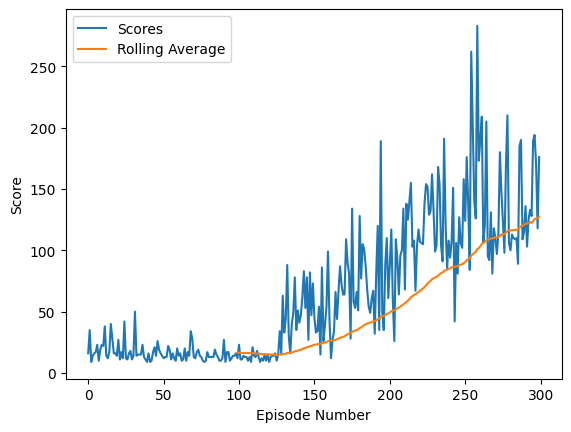

In [15]:
scores = pd.Series(scores, name="scores")
scores.describe()
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")